# Vision transformers

Vision Transformers (ViTs) consist of an encoder-decoder architecture, inspired by the structure of traditional Transformers used in Natural Language Processing (NLP). In the case of ViTs, the encoder processes image data, while the decoder can be used for tasks such as image generation or segmentation.

The encoder consists of multiple layers of self-attention and feed-forward networks, which allow the model to capture long-range dependencies between patches. The self-attention mechanism helps the model learn which patches are relevant to each other, enabling it to build a global understanding of the image.

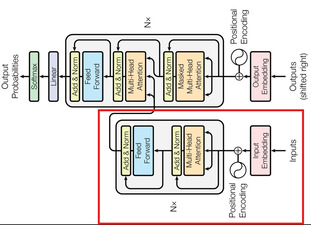

## Setup

In [21]:
!pip install einops

## Image Patching
Vision Transformers (ViTs) do not process images pixel-by-pixel like CNNs. Instead, they divide the image into patches, which are then transformed into vectors (embeddings) and used as "words" in a Transformer.



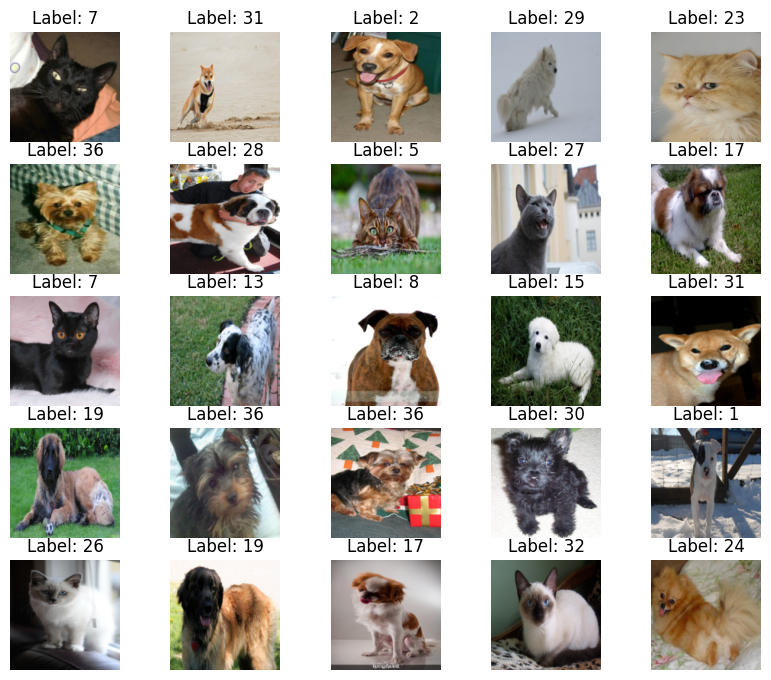

Number of Classes: 37


In [19]:
# Importing necessary libraries
import torch
from torchvision.datasets import OxfordIIITPet
import matplotlib.pyplot as plt
import random
from torchvision.transforms import Resize, ToTensor
from torchvision.transforms.functional import to_pil_image

# Custom Compose class to apply multiple transformations sequentially
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms
    def __call__(self, image, target):
        for transform in self.transforms:
            image = transform(image)
        return image, target

# Function to display a set of images from the dataset
def show_images(dataset, num_samples=25, cols=5):
    plt.figure(figsize=(10, 10))
    random_indices = random.sample(range(len(dataset)), num_samples)
    for i, idx in enumerate(random_indices):
        img, label = dataset[idx]
        plt.subplot((num_samples // cols) + 1, cols, i + 1)
        plt.imshow(to_pil_image(img))
        plt.title(f"Label: {label}")
        plt.axis('off')
    plt.show()

# Load the Oxford-IIIT Pet dataset with transformations applied
dataset = OxfordIIITPet(root=".", download=True, transforms=Compose([Resize((144, 144)), ToTensor()]))
# Display images from the dataset
show_images(dataset)
# Print number of classes
print("Number of Classes:", len(dataset.classes)  )

### How are the patches created?
For example, if we have a colored image of size 144×144 pixels with 3 channels (RGB) and we choose patches of size 8×8 pixels:
  - We divide the image into regions of 8×8 pixels.
  - We calculate how many patches there will be: 144/8=18⇒18×18=324 patches in total.
  - We convert each patch into a vector embedding:
      - Each patch is 8×8 pixels × 3 channels (RGB) = 192 numbers.
      - Using a Linear Layer, we transform it into a 128-dimensional embedding.
  - Final output: (324 patches, 128 features).



In [20]:
# Importing necessary libraries
from torch import nn
from einops.layers.torch import Rearrange
from torch import Tensor

class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=3, patch_size=8, emb_size=128):
        """
        Patch Embedding Module for Vision Transformer (ViT).

        Args:
        in_channels (int): Number of input channels (e.g., 3 for RGB images).
        patch_size (int): The size of each square patch.
        emb_size (int): The embedding dimension for each patch.
        """
        super().__init__()
        self.patch_size = patch_size  # Store patch size for reference
        # Define the patch embedding process
        self.projection = nn.Sequential(
            # Step 1: Rearrange the image into patches and flatten them
            # 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)' means:
            # - The image is divided into patches of size (patch_size x patch_size)
            # - Each patch is flattened into a single vector
            # - The patches are arranged in a sequence
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size),
            # Step 2: Project the flattened patches into an embedding space
            nn.Linear(patch_size * patch_size * in_channels, emb_size)
        )
    def forward(self, x: Tensor) -> Tensor:
        """
        Forward pass: Converts an image into patch embeddings.

        Args:
        x (Tensor): Input tensor of shape (batch_size, channels, height, width).

        Returns:
        Tensor: Output tensor of shape (batch_size, num_patches, emb_size).
        """
        x = self.projection(x)  # Apply the patch embedding projection
        return x

## Model

In [22]:
# Define the Attention class
class Attention(nn.Module):
    def __init__(self, dim, n_heads, dropout):
        """
        Initializes the Attention mechanism.

        Args:
        dim (int): The embedding dimension.
        n_heads (int): The number of attention heads.
        dropout (float): Dropout rate for regularization.
        """
        super().__init__()
        self.n_heads = n_heads # Number of attention heads
        # Multi-head self-attention mechanism
        self.att = torch.nn.MultiheadAttention(embed_dim=dim, num_heads=n_heads, dropout=dropout)
        # Linear layers to generate Q (Query), K (Key), and V (Value)
        self.q = torch.nn.Linear(dim, dim)  # Query: Represents the input making the query
        self.k = torch.nn.Linear(dim, dim)  # Key: Represents the address against which the query is compared
        self.v = torch.nn.Linear(dim, dim)  # Value: Contains the information that is retrieved

    def forward(self, x):
        """
        Forward pass of the Attention mechanism.

        Args:
        x (Tensor): Input tensor of shape (sequence_length, batch_size, embedding_dim).

        Returns:
        Tensor: Output after applying self-attention.
        """
        # Generate Query, Key, and Value vectors
        q = self.q(x)
        k = self.k(x)
        v = self.v(x)
        # Apply multi-head attention
        attn_output, attn_output_weights = self.att(q, k, v)
        return attn_output  # Return the output of the attention mechanism

In [23]:
# Define the PreNorm class
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        """
        Pre-Normalization Module.

        Args:
        dim (int): The embedding dimension.
        fn (function): A function (e.g., attention or feed-forward) that will be applied after normalization.
        """
        super().__init__()
        self.norm = nn.LayerNorm(dim)  # Apply Layer Normalization to stabilize training
        self.fn = fn  # Function to be applied to the normalized input (e.g., attention or MLP)

    def forward(self, x):
        """
        Forward pass of the Pre-Normalization.

        Args:
        x (Tensor): Input tensor of shape (batch_size, sequence_length, embedding_dim).

        Returns:
        Tensor: The output after applying normalization and the function `fn`.
        """
        return self.fn(self.norm(x))  # Normalize input and apply function

In [24]:
# Define the FeedForward class
class FeedForward(nn.Sequential):
    def __init__(self, dim, hidden_dim, dropout=0.):
        """
        FeedForward Neural Network used in Transformers.

        Args:
        dim (int): Input and output embedding dimension.
        hidden_dim (int): Hidden layer dimension.
        dropout (float, optional): Dropout rate for regularization. Default is 0.
        """
        super().__init__(
            nn.Linear(dim, hidden_dim),  # First linear transformation (input -> hidden)
            nn.GELU(),  # GELU activation function (Gaussian Error Linear Unit)
            nn.Dropout(dropout),  # Dropout for regularization
            nn.Linear(hidden_dim, dim),  # Second linear transformation (hidden -> output)
            nn.Dropout(dropout)  # Another dropout layer
        )

In [25]:
# Define the Residual class
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        """
        Residual Connection (Skip Connection) Module.

        Args:
        fn (function or module): A function (e.g., attention or feed-forward) applied to the input.
        """
        super().__init__()
        self.fn = fn  # Store the function that will be applied
    def forward(self, x, **kwargs):
        """
        Forward pass of the Residual Connection.

        Args:
        x (Tensor): Input tensor of shape (batch_size, sequence_length, embedding_dim).
        **kwargs: Additional arguments to be passed to `fn`.

        Returns:
        Tensor: The output after applying the function and adding the residual connection.
        """
        res = x  # Store the original input (residual connection)
        x = self.fn(x, **kwargs)  # Apply the function (e.g., attention or feed-forward)
        x += res  # Add the original input (residual connection)
        return x  # Return the final output

In [27]:
# Importing necessary library
from einops import repeat

# Define the ViT class
class ViT(nn.Module):
    def __init__(self, channels=3, img_size=144, patch_size=4, emb_dim=32, n_layers=6, out_dim=37, dropout=0.1, heads=2):
        """
        Vision Transformer (ViT) Implementation.

        Args:
        channels (int): Number of input channels (default: 3 for RGB images).
        img_size (int): Height and width of the input image (assumed square).
        patch_size (int): Size of each patch (patch_size x patch_size).
        emb_dim (int): Embedding dimension for patch representations.
        n_layers (int): Number of Transformer encoder layers.
        out_dim (int): Number of output classes.
        dropout (float): Dropout rate for regularization.
        heads (int): Number of attention heads in each Transformer block.
        """
        super(ViT, self).__init__()
        # Store attributes
        self.channels = channels
        self.height = img_size
        self.width = img_size
        self.patch_size = patch_size
        self.n_layers = n_layers
        # Compute the number of patches in the image
        num_patches = (img_size // patch_size) ** 2
        # Patch embedding: Converts image patches into embedding vectors
        self.patch_embedding = PatchEmbedding(in_channels=channels, patch_size=patch_size, emb_size=emb_dim)
        # Learnable parameters
        # - Positional encoding: allows the model to understand the relative position of the patches in the image and to maintain the spatial arrangement.
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, emb_dim))
        # - The Classification Token (CLS token): is a special token added at the beginning of the patch sequence, which aggregates information from all patches and is used to predict the image's category after processing by the Transformer.
        self.cls_token = nn.Parameter(torch.rand(1, 1, emb_dim))
        # Transformer Encoder: Stacked Transformer blocks
        self.layers = nn.ModuleList([])
        for _ in range(n_layers):
            transformer_block = nn.Sequential(
                # Multi-head self-attention with residual connection
                ResidualAdd(PreNorm(emb_dim, Attention(emb_dim, n_heads=heads, dropout=dropout))),
                # Feed-forward network with residual connection
                ResidualAdd(PreNorm(emb_dim, FeedForward(emb_dim, emb_dim, dropout=dropout)))
            )
            self.layers.append(transformer_block)
        # Classification head: Normalization + Linear layer
        self.head = nn.Sequential(nn.LayerNorm(emb_dim), nn.Linear(emb_dim, out_dim))
    def forward(self, img):
        """
        Forward pass of ViT.

        Args:
        img (Tensor): Input image tensor of shape (batch_size, channels, height, width).

        Returns:
        Tensor: Output logits for classification.
        """
        # Convert image into patch embeddings
        x = self.patch_embedding(img)  # Shape: (batch_size, num_patches, emb_dim)
        b, n, _ = x.shape  # Get batch size and number of patches
        # Add the classification token to the input sequence
        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b=b)  # Expand cls_token for batch size
        x = torch.cat([cls_tokens, x], dim=1)  # Shape: (batch_size, num_patches + 1, emb_dim)
        # Add positional embeddings to patch embeddings
        x += self.pos_embedding[:, :(n + 1)]
        # Pass through Transformer encoder layers
        for i in range(self.n_layers):
            x = self.layers[i](x)
        # Use the classification token's embedding for final prediction
        return self.head(x[:, 0, :])  # Output shape: (batch_size, out_dim)

# Instantiate and print model
model = ViT()
print(model)

ViT(
  (patch_embedding): PatchEmbedding(
    (projection): Sequential(
      (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=4, p2=4)
      (1): Linear(in_features=48, out_features=8, bias=True)
    )
  )
  (layers): ModuleList(
    (0-2): 3 x Sequential(
      (0): ResidualAdd(
        (fn): PreNorm(
          (norm): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
          (fn): Attention(
            (att): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=8, out_features=8, bias=True)
            )
            (q): Linear(in_features=8, out_features=8, bias=True)
            (k): Linear(in_features=8, out_features=8, bias=True)
            (v): Linear(in_features=8, out_features=8, bias=True)
          )
        )
      )
      (1): ResidualAdd(
        (fn): PreNorm(
          (norm): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
          (fn): FeedForward(
            (0): Linear(in_features=8, out_features=8, bias=

## Training

In [28]:
# Importing necessary libraries
from torch.utils.data import DataLoader, random_split

train_ratio = 0.8
valid_ratio = 0.1
test_ratio = 0.1
train_size = int(train_ratio * len(dataset))
valid_size = int(valid_ratio * len(dataset))
test_size = len(dataset) - train_size - valid_size
train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# Importing necessary libraries
import torch.optim as optim
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
model = ViT().to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

for epoch in range(500):
    epoch_train_losses = []
    epoch_train_correct = 0
    epoch_train_total = 0
    epoch_val_losses = []
    epoch_val_correct = 0
    epoch_val_total = 0
    model.train()
    for step, (inputs, labels) in enumerate(train_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_train_losses.append(loss.item())
        preds = outputs.argmax(dim=1)
        epoch_train_correct += (preds == labels).sum().item()
        epoch_train_total += labels.size(0)
    model.eval()
    with torch.no_grad():
        for step, (inputs, labels) in enumerate(valid_dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            epoch_val_losses.append(loss.item())
            preds = outputs.argmax(dim=1)
            epoch_val_correct += (preds == labels).sum().item()
            epoch_val_total += labels.size(0)
    train_loss = np.mean(epoch_train_losses)
    val_loss = np.mean(epoch_val_losses)
    train_acc = epoch_train_correct / epoch_train_total
    val_acc = epoch_val_correct / epoch_val_total
    print(f"Epoch {epoch}: Train Loss: {train_loss:.5f}, Train Accuracy: {train_acc:.5f}, Validation Loss: {val_loss:.5f}, Validation Accuracy: {val_acc:.5f}")

# Testing

In [ ]:
model.eval()
test_losses = []
test_correct = 0
test_total = 0
with torch.no_grad():
    for step, (inputs, labels) in enumerate(test_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_losses.append(loss.item())
        preds = outputs.argmax(dim=1)
        test_correct += (preds == labels).sum().item()
        test_total += labels.size(0)
test_loss = np.mean(test_losses)
test_acc = test_correct / test_total
print(test_correct)
print(test_total)
print(f"Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.5f}")